In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel
from torch.nn.functional import softmax, one_hot
import pandas as pd 
import os
from tqdm import tqdm
from torchvision.transforms import transforms
import matplotlib.cm as cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import numpy as np
from scipy import signal
import wandb

In [5]:
df = pd.read_csv("../this_studio/train.csv")

In [6]:
df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [7]:
classes = df['expert_consensus'].unique()

In [8]:
mapping = {
    c:i for i, c in enumerate(classes)
}

In [9]:
num_classes = classes.shape[0]

In [10]:
cmap = cm.get_cmap("viridis")

/tmp/ipykernel_114915/4067785149.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


In [11]:
row = df.sample(n=1).iloc[0,]

In [12]:
def paired_spectrogram(spec_id, offset):
    consolidated_spec = pd.read_parquet(f"./train_spectrograms/{spec_id}.parquet")
    start = offset
    end = offset + 600
    return consolidated_spec[(consolidated_spec["time"] <= end) & (consolidated_spec["time"] >= start)]

In [13]:
spec = paired_spectrogram(row["spectrogram_id"], row["spectrogram_label_offset_seconds"])
spec

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
190,381,33.419998,58.770000,56.040001,64.220001,73.300003,40.580002,38.209999,36.290001,34.439999,...,0.71,0.76,0.69,0.57,0.64,0.54,0.59,0.47,0.50,0.24
191,383,19.250000,50.099998,51.959999,52.169998,52.279999,39.369999,25.820000,23.719999,11.400000,...,0.73,1.14,1.18,0.75,1.01,1.05,0.76,0.99,0.65,0.84
192,385,21.950001,49.450001,44.279999,40.340000,66.849998,32.880001,33.439999,41.980000,15.400000,...,1.52,1.11,1.43,1.51,1.18,1.51,1.07,1.18,1.01,0.96
193,387,37.630001,50.200001,66.769997,77.139999,88.059998,64.769997,61.970001,47.830002,31.459999,...,1.20,1.22,1.10,0.93,0.97,1.03,1.06,1.14,1.07,0.91
194,389,63.119999,107.059998,127.529999,116.760002,124.209999,43.770000,50.540001,58.720001,28.530001,...,1.54,0.92,1.09,1.14,0.96,1.00,1.06,0.84,1.02,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,971,34.430000,81.809998,104.919998,97.269997,91.459999,63.299999,41.299999,35.560001,31.070000,...,0.29,0.45,0.53,0.58,0.47,0.61,0.60,0.39,0.40,0.43
486,973,29.000000,46.360001,51.240002,60.020000,59.340000,37.259998,43.500000,30.680000,38.099998,...,0.61,0.49,0.48,0.59,0.58,0.62,0.50,0.57,0.62,0.59
487,975,24.320000,84.930000,109.330002,124.690002,113.370003,102.669998,44.910000,43.509998,39.119999,...,0.36,0.39,0.38,0.38,0.37,0.31,0.28,0.30,0.41,0.55
488,977,74.080002,89.660004,122.809998,136.029999,111.779999,74.970001,60.820000,37.849998,47.139999,...,0.62,0.95,0.90,1.08,0.95,0.83,0.92,0.84,0.93,0.57


In [ ]:
def plot_spec(df):
    fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs, prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(spec[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix)
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_ylabel("Freq")
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(spec.iloc[0, 0], spec.iloc[-1, 0], (spec.iloc[-1, 0]-spec.iloc[0, 0])//4))
        ax.set_xlabel("Seconds")

    plt.tight_layout()

    canvas = FigureCanvasAgg(fig)
    # canvas.draw()
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.buffer_rgba())

    return pil_image
    
plot_spec(spec)

In [ ]:
class spectrogramDataset(Dataset):
    def __init__(self,csv_file,path="../this_studio/train_spectrograms/",transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.path = path
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        spec_id = df.iloc[idx,:]['spectrogram_id']
        label = df.iloc[idx,:]['expert_consensus']
        spec_label_offset = df.iloc[idx,:]["spectrogram_label_offset_seconds"]
        
        spectrogram_path = os.path.join(self.path,str(spec_id)+".parquet")
        spectrogram = pd.read_parquet(spectrogram_path).drop('time',axis=1)
        spectrogram = paired_spectrogram(spec_id, spec_label_offset)
        spectrogram = plot_spec(spectrogram)
        # spectrogram = Image.fromarray((cmap(spectrogram) * 255).astype(np.uint8))
        # plt.imshow(spectrogram)
        spectrogram = spectrogram.astype(np.uint8)
        
        if self.transform:
            spectrogram = self.transform(spectrogram)[:3, :, :]
        
        return spectrogram,mapping[label]
        
        

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
#     transforms.CenterCrop(224),  # Center crop to maintain aspect ratio
    transforms.ToTensor(),  # Convert to PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225])  # Normalize (optional)
])

In [ ]:
dataset = spectrogramDataset("../this_studio/train.csv",transform=transform)

In [ ]:
dataset.__len__()

106800

/tmp/ipykernel_114915/3191168940.py:21: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 0)

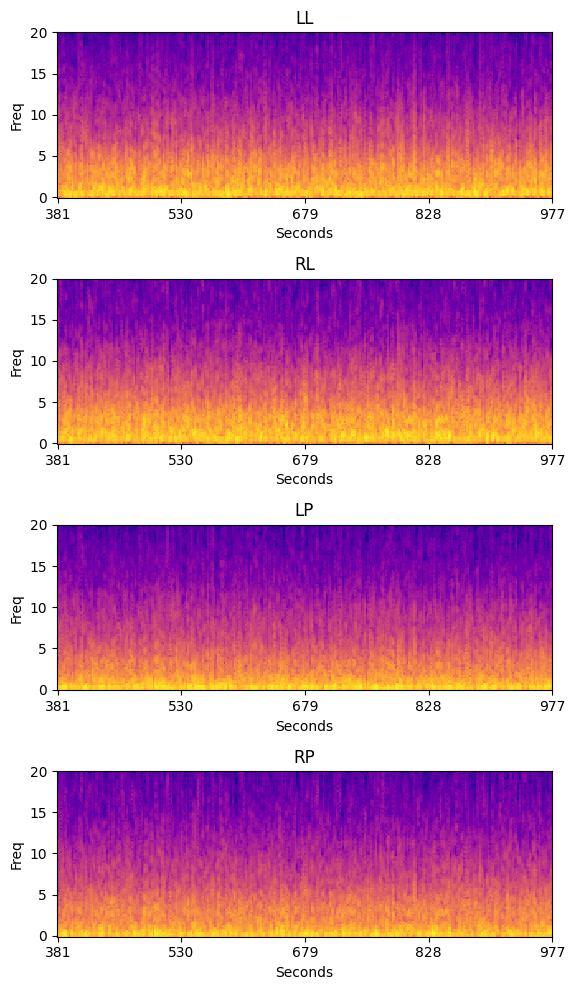

In [ ]:
dataset.__getitem__(3)

In [ ]:
train_len = int(.8*len(dataset))
val_len = len(dataset)-train_len

In [ ]:
val_len

21360

In [ ]:
train_set,val_set = torch.utils.data.random_split(dataset,[train_len,val_len])

In [ ]:
train_loader = DataLoader(train_set,batch_size=5,shuffle=True, num_workers = 2, prefetch_factor=1)
val_loader = DataLoader(val_set, batch_size=5,shuffle=True,num_workers = 2, prefetch_factor = 1)

In [ ]:
class ViTClassifier(torch.nn.Module):
    def __init__(self,num_classes=num_classes):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.classifier = torch.nn.Linear(self.vit.config.hidden_size,num_classes)
        
    def forward(self,images):
        output = self.vit(images)
        output = self.classifier(output.last_hidden_state[:,0])
        output = softmax(output,dim=1)
        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ViTClassifier(num_classes=num_classes).to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
loss_fn = torch.nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
args = {
    "lr":.001,
    "loss":"KLDivloss"
}

In [ ]:
wandb.init(config=args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jatinsingh. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch(model, log_freq=1)

[]

In [ ]:
num_epochs = 5

#early stopping
patience = 5
early_stopping_counter = 0
best_validation_loss = float('inf')

#model checkpoint
checkpoint_path = "./Harmful-brain-activity-pytorch/models/checkpoints/ck_model.pth"

In [ ]:
for epoch in range(num_epochs):
    pbar = tqdm(train_loader)
    
    for spectrograms, labels in pbar:
        labels_onehot = one_hot(labels,num_classes=num_classes).float().to(device)
        spectrograms = spectrograms.to(device)
        optimizer.zero_grad()
        
        outputs = model(spectrograms)
        loss = loss_fn(outputs.log(),labels_onehot)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'train loss: {loss}')
    wandb.log({"train loss":loss})

    
        
    with torch.no_grad():
        correct = total=val_loss = 0
        pbar = tqdm(val_loader)
        
        for spectrograms,labels in pbar:
            labels = labels.to(device)
            labels_onehot = one_hot(labels,num_classes).float()
            spectrograms = spectrograms.to(device)
            outputs = model(spectrograms)
            
            _, predicted = torch.max(outputs.data,1)
            
            total+=labels.size(0)
            
            correct += (predicted==labels).sum().item()
            loss = loss_fn(outputs.log(),labels_onehot).item()
            val_loss+=loss
            pbar.set_description(f'val loss: {loss}')
        wandb.log({"val loss":loss})

        accuracy = 100 * correct/total
        
        kl_divergence = val_loss / len(val_loader)
        
        wandb.log({"accuracy":accuracy,"kl divergence":kl_divergence})
        
        print("Validation Accuracy: ", accuracy)
        print("KL divergence loss: ",kl_divergence )

        if best_validation_loss - val_loss < .01:
            best_validation_loss = val_loss
            early_stopping_counter = 0
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_path)
        else:
            early_stopping_counter+=1
        
        if early_stopping_counter >= patience:
            break; 
        
torch.save(model.state_dict(),'../this_studio/Harmful-brain-activity-pytorch/trained_model/trained_model.pt')        

val loss: 1.6309314966201782: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Validation Accuracy:  20.0
KL divergence loss:  1.6829172372817993


val loss: 0.8028178215026855: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Validation Accuracy:  60.0
KL divergence loss:  1.1787062883377075


val loss: 1.3655271530151367: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Validation Accuracy:  60.0
KL divergence loss:  1.0078765749931335


val loss: 0.9612978100776672: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Validation Accuracy:  70.0
KL divergence loss:  1.0199852287769318


val loss: 1.298303246498108: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it] 


Validation Accuracy:  30.0
KL divergence loss:  1.1911728978157043
